In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import math

np.random.seed(42)

if tf.config.list_physical_devices('GPU'):
  print("GPU is available")
else:
  print("GPU is not available")

GPU is available


In [ ]:
class SimpleNN:
  def __init__(self, input_size, hidden_size, output_size):
    self.model = Sequential([
      Dense(hidden_size, activation='relu', input_shape=(input_size,)),
      Dense(output_size, activation='softmax')
  ])

  def predict(self, inputs):
    return self.model(inputs)

  def get_weights(self):
    return self.model.get_weights()

  def set_weights(self, weights):
    self.model.set_weights(weights)

class PSOptimizer:
  def __init__(self, model, w, c1, c2, num_particles=30, is_global_neighborhood=True):
    self.model = model
    self.num_particles = num_particles
    self.is_global_neighborhood = is_global_neighborhood
    self.w = w
    self.c1 = c1
    self.c2 = c2

    initial_weights = self.model.get_weights()
    self.particles = [
      [w + np.random.uniform(-0.1, 0.1, w.shape) for w in initial_weights]
        for _ in range(num_particles)
      ]
    self.velocities = [self._initialize_velocity() for _ in range(num_particles)]

    self.personal_bests = self.particles.copy()
    self.personal_best_losses = [float('inf')] * num_particles
    self.global_best = None
    self.global_best_loss = float('inf')

    self._evaluate_particles()

  def _initialize_velocity(self):
    return [np.ones_like(w)* np.random.uniform(0, 1, (w.shape)) for w in self.model.get_weights()]

  def _evaluate_particles(self):
    for i, particle in enumerate(self.particles):
      self.model.set_weights(particle)
      loss = self._evaluate_loss()
      if loss < self.personal_best_losses[i]:
        self.personal_bests[i] = particle
        self.personal_best_losses[i] = loss
      if loss < self.global_best_loss:
        self.global_best = particle
        self.global_best_loss = loss
    self.model.set_weights(self.global_best)

  def _evaluate_loss(self):
    predictions = self.model.predict(inputs)
    loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)
    return tf.reduce_mean(loss).numpy()

  def step(self):
    for i, (particle, velocity) in enumerate(zip(self.particles, self.velocities)):
      new_velocity = []
      new_particle = []

      for j, (p, v, p_best, g_best) in enumerate(zip(particle, velocity, self.personal_bests[i], self.global_best)):
        r1 = np.random.rand(*p.shape)
        r2 = np.random.rand(*p.shape)

        cognitive = self.c1 * r1 * (p_best - p)
        social = None
        if self.is_global_neighborhood:
          social = self.c2 * r2 * (g_best - p) # global neigh
        else:
          # chain topology
          left, right = None, None
          if i == 0:
            left = -1
            right = i+1
          elif i == len(self.particles)-1:
            left = i-1
            right = 0
          else:
            left = i-1
            right = i+1

          if self.personal_best_losses[left] < self.personal_best_losses[right]:
            social = self.c2 * r2 * (self.personal_bests[left][j] - p)
          else:
            social = self.c2 * r2 * (self.personal_bests[right][j] - p)

        new_v = self.w * v + cognitive + social
        new_p = p + new_v

        new_velocity.append(new_v)
        new_particle.append(new_p)

      self.velocities[i] = new_velocity
      self.particles[i] = new_particle

    self._evaluate_particles()

# parameters
input_size = 10
hidden_size = 5
output_size = 2

# Create the model
model = SimpleNN(input_size, hidden_size, output_size)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Dummy data for training
inputs = np.random.randn(5, input_size)
labels = np.array([0, 1, 0, 1, 0])

# PSO optimizer
pso_optimizer = PSOptimizer(model, w=0.6, c1=2.2, c2=2, num_particles=20, is_global_neighborhood=True)
for epoch in range(10):
    pso_optimizer.step()

    predictions = model.predict(inputs)
    loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)
    print(f'Epoch [{epoch+1}], Loss: {tf.reduce_mean(loss).numpy():.4f}')

# test the model with dummy input
test_input = np.random.randn(1, input_size)
prediction = model.predict(test_input)
print("Test Prediction:", prediction)

Epoch [1], Loss: 0.7063
Epoch [2], Loss: 0.4957
Epoch [3], Loss: 0.3339
Epoch [4], Loss: 0.1729
Epoch [5], Loss: 0.0038
Epoch [6], Loss: 0.0004
Epoch [7], Loss: 0.0004
Epoch [8], Loss: 0.0001
Epoch [9], Loss: 0.0000
Epoch [10], Loss: 0.0000
Test Prediction: tf.Tensor([[1.0000000e+00 8.3772087e-23]], shape=(1, 2), dtype=float32)


In [ ]:
class MFOptimizer:
  def __init__(self, model, num_moths=30, max_num_flames=15):
    self.model = model
    self.num_moths = num_moths
    self.max_num_flames = max_num_flames

    initial_weights = self.model.get_weights()
    self.swarm = np.array([
      [w + np.random.uniform(-0.1, 0.1, w.shape) for w in initial_weights]
      for _ in range(num_moths)
    ], dtype=object)

    self.swarm_losses = np.full(num_moths, np.inf)

    self.best_flames = None
    self.best_flames_losses = np.full(max_num_flames, np.inf)

    self.double_swarm = None
    self.double_swarm_losses = np.full(2*num_moths, np.inf)

    self.previous_swarm = None
    self.previous_swarm_losses = None

    self.global_best = None
    self.global_best_loss = float('inf')

    self._evaluate_particles()

  def _evaluate_particles(self):
    for i, moth in enumerate(self.swarm):
      self.model.set_weights(moth)
      loss = self._evaluate_loss()
      self.swarm_losses[i] = loss

    if self.best_flames is not None:
      self.model.set_weights(self.best_flames[0])

  def _evaluate_loss(self):
    predictions = self.model.predict(inputs)
    loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)
    return tf.reduce_mean(loss).numpy()

  def step(self, current_epoch, max_epochs):
    flame_num = round(self.max_num_flames - current_epoch * ((self.max_num_flames-1)/max_epochs))

    if current_epoch == 0 and self.best_flames == None:
      sorted_indices = np.argsort(self.swarm_losses)
      self.best_flames_losses = self.swarm_losses[sorted_indices]
      self.best_flames = self.swarm[sorted_indices]
      assert len(self.best_flames) == len(self.best_flames_losses)
    else:
      self.double_swarm = np.concatenate((self.previous_swarm, self.best_flames), axis=0)
      self.double_swarm_losses = np.concatenate((self.previous_swarm_losses, self.best_flames_losses), axis=0)
      assert self.double_swarm.shape[0] == self.double_swarm_losses.shape[0]

      double_swarm_indices = np.argsort(self.double_swarm_losses)

      self.double_swarm = self.double_swarm[double_swarm_indices]
      self.double_swarm_losses = self.double_swarm_losses[double_swarm_indices]

      self.best_flames_losses = self.double_swarm_losses[0:self.num_moths]
      self.best_flames = self.double_swarm[0:self.num_moths]

    self.previous_swarm = self.swarm.copy()
    self.previous_swarm_losses= self.swarm_losses.copy()

    a = -1 + current_epoch * ((-1)/max_epochs)

    for i in range(self.num_moths):
      distance = abs(self.best_flames[i]-self.swarm[i])
      b = 1
      t = (a-1) * np.random.random() + 1

      if i <= flame_num:
        self.swarm[i] = distance * math.exp(b * t) * math.cos(t * 2 * math.pi) + self.best_flames[i]
      else:
        self.swarm[i] = distance * math.exp(b * t) * math.cos(t * 2 * math.pi) + self.best_flames[flame_num]

    self._evaluate_particles()

In [ ]:
# dummy data for training
inputs = np.random.randn(5, input_size)
labels = np.array([0, 1, 0, 1, 0])

mfo_optimizer = MFOptimizer(model)
for epoch in range(10):
    mfo_optimizer.step(epoch, 10)

    predictions = model.predict(inputs)
    loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)
    print(f'Epoch [{epoch+1}], Loss: {tf.reduce_mean(loss).numpy():.4f}')

# test the model with dummy input
test_input = np.random.randn(1, input_size)
prediction = model.predict(test_input)
print("Test Prediction:", prediction)

Epoch [1], Loss: 0.6700
Epoch [2], Loss: 0.6700
Epoch [3], Loss: 0.6547
Epoch [4], Loss: 0.6172
Epoch [5], Loss: 0.6172
Epoch [6], Loss: 0.5904
Epoch [7], Loss: 0.5845
Epoch [8], Loss: 0.5845
Epoch [9], Loss: 0.5845
Epoch [10], Loss: 0.5243
Test Prediction: tf.Tensor([[0.9952278  0.00477218]], shape=(1, 2), dtype=float32)


In [ ]:
def levy_flight(alpha):
  step = np.random.normal(0,1) / (np.abs(np.random.normal(0,1))**(1/alpha))
  return step

def logistic_map(x, r):
  return r*x*(1-x)

class NLCMFOptimizer:
  def __init__(self, model, num_moths=30, max_num_flames=15):
    self.model = model
    self.num_moths = num_moths
    self.max_num_flames = max_num_flames
    self.aplha = 1.5
    self.r = 3.99
    self.xchaotic = np.random.random()

    initial_weights = self.model.get_weights()
    self.swarm = np.array([
      [w + np.random.uniform(-0.1, 0.1, w.shape) for w in initial_weights]
      for _ in range(num_moths)
    ], dtype=object)

    self.swarm_losses = np.full(num_moths, np.inf)

    self.best_flames = None
    self.best_flames_losses = np.full(max_num_flames, np.inf)

    self.double_swarm = None
    self.double_swarm_losses = np.full(2*num_moths, np.inf)

    self.previous_swarm = None
    self.previous_swarm_losses = None

    self.global_best = None
    self.global_best_loss = float('inf')

    self._evaluate_particles()

  def _evaluate_particles(self):
    for i, moth in enumerate(self.swarm):
      self.model.set_weights(moth)
      loss = self._evaluate_loss()
      self.swarm_losses[i] = loss

    if self.best_flames is not None:
      self.model.set_weights(self.best_flames[0])

  def _evaluate_loss(self):
    predictions = self.model.predict(inputs)
    loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)
    return tf.reduce_mean(loss).numpy()

  def step(self, current_epoch, max_epochs):
    flame_num = round(self.max_num_flames - current_epoch * ((self.max_num_flames-1)/max_epochs))

    if current_epoch == 0 and self.best_flames == None:
      sorted_indices = np.argsort(self.swarm_losses)
      self.best_flames_losses = self.swarm_losses[sorted_indices]
      self.best_flames = self.swarm[sorted_indices]
      assert len(self.best_flames) == len(self.best_flames_losses)
    else:
      self.double_swarm = np.concatenate((self.previous_swarm, self.best_flames), axis=0)
      self.double_swarm_losses = np.concatenate((self.previous_swarm_losses, self.best_flames_losses), axis=0)
      assert self.double_swarm.shape[0] == self.double_swarm_losses.shape[0]

      double_swarm_indices = np.argsort(self.double_swarm_losses)

      self.double_swarm = self.double_swarm[double_swarm_indices]
      self.double_swarm_losses = self.double_swarm_losses[double_swarm_indices]

      self.best_flames_losses = self.double_swarm_losses[0:self.num_moths]
      self.best_flames = self.double_swarm[0:self.num_moths]

    self.previous_swarm = self.swarm.copy()
    self.previous_swarm_losses= self.swarm_losses.copy()

    a = -1 + current_epoch * ((-1)/max_epochs)

    for i in range(self.num_moths):
      distance = abs(self.best_flames[i]-self.swarm[i])
      levy_step = levy_flight(a*self.aplha)
      self.xchaotic = logistic_map(self.xchaotic, self.r)

      if i <= flame_num:
        self.swarm[i] = distance * math.exp(levy_step) * math.cos(self.xchaotic * 2 * math.pi) + self.best_flames[i]
      else:
        self.swarm[i] = distance * math.exp(levy_step) * math.cos(self.xchaotic * 2 * math.pi) + self.best_flames[flame_num]

    self._evaluate_particles()

In [ ]:
def compare_optimizers_with_average(model_class, input_size, hidden_size, output_size, inputs, labels, optimizers, epochs, iterations):
    average_loss_history = {name: [] for name in optimizers.keys()}
    optimizer_labels = list(optimizers.keys())

    for iteration in range(iterations):
        print(f"Iteration {iteration + 1}/{iterations}")
        loss_history = []

        for optimizer_name, optimizer_class in optimizers.items():
            model = model_class(input_size, hidden_size, output_size)
            optimizer = optimizer_class(model)
            epoch_losses = []

            if optimizer_name.startswith("PSO"):
                for epoch in range(epochs):
                    optimizer.step()
                    predictions = model.predict(inputs)
                    loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)
                    epoch_losses.append(tf.reduce_mean(loss).numpy())
            elif optimizer_name.startswith("MFO"):
                for epoch in range(epochs):
                    optimizer.step(current_epoch=epoch, max_epochs=epochs)
                    predictions = model.predict(inputs)
                    loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)
                    epoch_losses.append(tf.reduce_mean(loss).numpy())
            else:
                # For tensorflow optimizers
                model.model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')
                history = model.model.fit(inputs, labels, epochs=epochs, verbose=0)
                epoch_losses = history.history['loss']

            loss_history.append(epoch_losses)

            if len(average_loss_history[optimizer_name]) == 0:
                average_loss_history[optimizer_name] = np.array(epoch_losses)
            else:
                average_loss_history[optimizer_name] += np.array(epoch_losses)

    for optimizer_name in average_loss_history:
        average_loss_history[optimizer_name] /= iterations

    plot_average_loss_history(average_loss_history, optimizer_labels)


# Function to plot average loss history
def plot_average_loss_history(average_loss_history, labels):
    for label in labels:
        plt.plot(average_loss_history[label], label=label)
    plt.xlabel("Epochs")
    plt.ylabel("Average Loss")
    plt.legend()
    plt.title("Average Loss Comparison Over Multiple Iterations")
    plt.show()

Iteration 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10


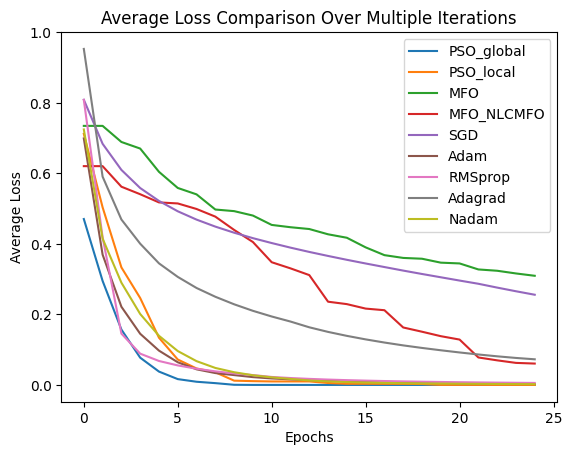

In [ ]:
# Define optimizers to compare
lr = 0.1
optimizers = {
    "PSO_global": lambda model: PSOptimizer(model, w=0.6, c1=2.2, c2=2, num_particles=20, is_global_neighborhood=True),
    "PSO_local": lambda model: PSOptimizer(model, w=0.6, c1=2.2, c2=2, num_particles=20, is_global_neighborhood=False),
    "MFO": lambda model: MFOptimizer(model, num_moths=20, max_num_flames=20),
    "MFO_NLCMFO": lambda model: NLCMFOptimizer(model, num_moths=20, max_num_flames=20),
    "SGD": lambda model: tf.keras.optimizers.SGD(learning_rate=lr),
    "Adam": lambda model: tf.keras.optimizers.Adam(learning_rate=lr),
    "RMSprop": lambda model: tf.keras.optimizers.RMSprop(learning_rate=lr),
    "Adagrad": lambda model: tf.keras.optimizers.Adagrad(learning_rate=lr),
    "Nadam": lambda model: tf.keras.optimizers.Nadam(learning_rate=lr),
}

iterations = 10
compare_optimizers_with_average(SimpleNN, input_size, hidden_size, output_size, inputs, labels, optimizers, epochs=25, iterations = iterations)